In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI
from langchain_experimental.tools import PythonAstREPLTool

llm = ChatOpenAI(model="gpt-4o-mini")

db = SQLDatabase.from_uri("sqlite:///warehouse2.db")

sql_toolkit = SQLDatabaseToolkit(db=db, llm=llm)

python_repl= PythonAstREPLTool()

In [3]:
inventory_agent = create_agent(
    model=llm,
    tools=[python_repl, *sql_toolkit.get_tools()],
    system_prompt="""You are the Inventory Manager. You can:
    1. Query inventory levels using SQL
    2. Update inventory quantities
    3. Check items below reorder point
    
    4. if generating code, make sure to use the correct , make sure that code returns expected value finally.
    think properly before generating code and generate all the required code at once.

    Important Instructions:
    - Always end your response with a clear CONCLUSION: stating what you found and any actions taken
    - When checking inventory, provide specific numbers
    - For updates, confirm the before and after quantities
    - Keep responses focused and concise
    - Use proper SQL syntax and verify data before updates

    Example format:
    *Analysis/Actions taken*
    CONCLUSION: Found X items below reorder point. Updated inventory for item Y from A to B units."""
)

In [4]:
order_agent = create_agent(
    model=llm,
    tools=[python_repl, *sql_toolkit.get_tools()],
    system_prompt="""You are the Order Processor. You can only :
    1. Process new orders
    2. Update order status
    3. Check order details

    Important Instructions:
    - Always end your response with a clear CONCLUSION: stating what you found and any actions taken
    
    - For order updates, confirm the new status
    - Provide specific quantities and order details
    - Keep responses focused and concise
    - You can only process orders and update order status. U cannot update inventory.
    Example format:
    *Analysis/Actions taken*
    CONCLUSION: Order XYZ processed successfully. Updated status from A to B. Inventory adjusted."""
)


In [5]:
analytics_agent = create_agent(
    model=llm,
    tools=[python_repl, *sql_toolkit.get_tools()],
    system_prompt="""You are the Analytics Manager. You can:
    1. Analyze sales trends
    2. Generate inventory reports
    3. Calculate key metrics
    4. Provide recommendations

    Important Instructions:
    - Always end your response with a clear CONCLUSION: stating your findings and recommendations
    - Provide specific numbers and insights
    - Keep responses focused and concise
    - Use clear visualizations when needed

    Example format:
    *Analysis performed*
    CONCLUSION: Analysis shows X trend over Y period. Recommend taking Z action."""
)

In [6]:
system_prompt = """
You are a warehouse operations supervisor managing these workers: InventoryManager, OrderProcessor, AnalyticsManager.
Below are the tasks handled by each worker:

InventoryManager: InventoryManager can check stock levels, update inventory, and manage reordering
OrderProcessor: OrderProcessor can process orders, update order status, and manage order fulfillment 
AnalyticsManager: AnalyticsManager can analyze sales trends, inventory turnover, and generate reports

Before processing orders, InventoryManager must ensure sufficient stock.

Given the following request, determine which worker should act next.

When all necessary tasks are completed, respond with FINISH.

Once the task  is complete respond with FINISH.
"""

options = ["FINISH", "InventoryManager", "OrderProcessor", "AnalyticsManager"]

In [7]:
from typing import TypedDict,Annotated
import operator

class MyState(TypedDict):
    messages : Annotated[list,operator.add]
    next: str

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="messages"),
    ("system", """Given the conversation above, 
     who should act next? Or should we FINISH? Select one of: """ + str(options)),
])



def supervisor_agent(state: MyState) -> MyState:
    llm = ChatOpenAI(model="gpt-4o")

    chain =  prompt | llm
    next = chain.invoke(state).content

    print("Supervisor decided next agent:", next)

    return {
        "next": next

    }

supervisor_agent({
    "messages": [   
        {"role": "user", "content": "What are the top 3 best selling products last month?"}
    ]
})

Supervisor decided next agent: AnalyticsManager


{'next': 'AnalyticsManager'}

In [ ]:
from langchain.messages import HumanMessage

def agent_node(agent,name):

    def node(state: MyState) -> MyState:
        result= agent.invoke(state)
        resp=result['messages'][-1].content
        print((f"{name} response: {resp}"))
        return  {
            "messages": [HumanMessage(content=resp)]
        }
    
    return node

In [10]:
inventory_node = agent_node(inventory_agent,"InventoryManager")
order_node = agent_node(order_agent,"OrderProcessor")
analytics_node = agent_node(analytics_agent,"AnalyticsManager")

In [11]:
def where_to_go(state):

    return state['next']

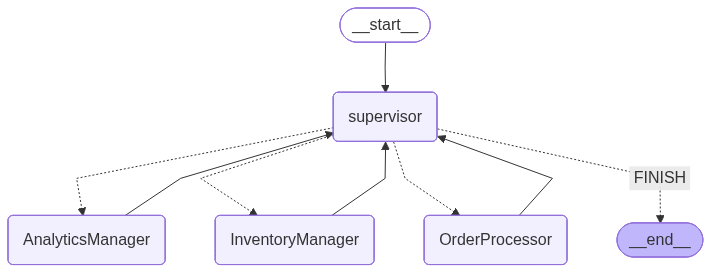

In [ ]:
from langgraph.graph import END, StateGraph, START
from langchain_core.runnables import RunnableLambda

workflow= StateGraph(MyState)
workflow.add_node("supervisor",supervisor_agent)
workflow.add_node("InventoryManager",inventory_agent)
workflow.add_node("OrderProcessor",order_node)
workflow.add_node("AnalyticsManager",analytics_node)

workflow.add_conditional_edges("supervisor", lambda state: state['next'], {
    "FINISH": END,
    "InventoryManager": "InventoryManager",
    "OrderProcessor": "OrderProcessor",
    "AnalyticsManager": "AnalyticsManager"
})

workflow.add_edge("InventoryManager", "supervisor")
workflow.add_edge("OrderProcessor", "supervisor")
workflow.add_edge("AnalyticsManager", "supervisor")

workflow.set_entry_point("supervisor")

graph=workflow.compile()
graph

In [13]:
graph.invoke(
    {
        "messages": [   
            {"role": "user", "content": "Process order ORD001 and update inventory accordingl"}
        ]
    }
)

Supervisor decided next agent: InventoryManager
InventoryManager response: *Analysis/Actions taken*  
- For order `ORD001`, the following items were processed:  
  - SKU003: Ordered Quantity: 3, Available Before Processing: 2 → Available After Processing: -1  
  - SKU004: Ordered Quantity: 4, Available Before Processing: 26 → Available After Processing: 22  

The inventory for SKU003 went negative, indicating insufficient stock for the order. 

CONCLUSION: SKU003 is below reorder level with a quantity of -1 units after fulfilling order ORD001. Inventory for SKU004 was updated from 26 to 22 units. Immediate action is necessary for restocking SKU003.
Supervisor decided next agent: InventoryManager
InventoryManager response: *Analysis/Actions taken*  
- For order `ORD001`, the following items were processed:  
  - SKU003: Ordered Quantity: 3, Available Before Processing: -1 → Available After Processing: -1 (remains insufficient)  
  - SKU004: Ordered Quantity: 4, Available Before Processi

KeyboardInterrupt: 